DATA STRUCTURES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import time
import re

class KnapsackInstance:
    """
    Enkel datastruktur for å lagre én instans av et multi-knapsack-problem.
    """

    def __init__(self, name: str, num_items: int, 
                 num_knapsacks: int, capacities: List[int], 
                 profits: List[int], weights: np.ndarray, 
                 optimal_value: int = None):
        """
        Oppretter et nytt knapsack-objekt med all nødvendig informasjon.

        Args:
            name: Navn/ID på instansen (for referanse i analyser og plotting).
            num_items: Antall gjenstander (kolonner i weight-matrisen).
            num_knapsacks: Antall knapsakker / kapasitetsbegrensninger.
            capacities: Liste med kapasitet for hver knapsakk.
            profits: Liste med gevinst/verdi for hver gjenstand.
            weights: Vektmatrise (rad = knapsakk, kolonne = gjenstand).
            optimal_value: Kjent optimal løsning (om den er oppgitt i datasettet).
        """
        self.name = name
        self.num_items = num_items
        self.num_knapsacks = num_knapsacks
        self.capacities = capacities
        self.profits = profits
        self.weights = weights
        self.optimal_value = optimal_value


DATA LOADING

In [2]:
class DataLoader:
    """
    Ansvarlig for å lese inn knapsack-instanser fra ulike filformater.
    """

    def load_or_library(self, filepath, instance_names):
        """
        Leser OR-Library-instanser fra mknap2.txt-filen.

        Args:
            filepath: Sti til mknap2.txt
            instance_names: Liste med instansnavn (f.eks. ["WEING3", "WEISH08"]).
        """
        # Les hele filen som én streng
        with open(filepath, 'r') as file:
            content = file.read()

        # Hjelpefunksjon for å fjerne kommentarer ('//') og whitespace
        def clean_line(line: str) -> str:
            if '//' in line:
                line = line[:line.index('//')]
            return line.strip()

        instances = []
        content_lower = content.lower()

        for name in instance_names:
            # Finn starten på blokken som tilhører denne instansen
            search_pattern = f"problem {name}.DAT"
            search_lower = search_pattern.lower()

            idx = content_lower.find(search_lower)
            if idx == -1:
                print(f"Warning: Instance {name} not found")
                continue

            # Finn første linjeskift etter instans-headeren
            start_pos = content.find('\n', idx)
            if start_pos == -1:
                print(f"Warning: Malformed block for {name}")
                continue
            start_pos += 1

            # Hopp over tomme linjer, kommentarer og ++++ til vi finner linjen med m n
            while start_pos < len(content):
                line_end = content.find('\n', start_pos)
                if line_end == -1:
                    line_end = len(content)
                first_line = clean_line(content[start_pos:line_end])
                if first_line and not first_line.startswith('++++'):
                    break
                start_pos = line_end + 1

            # Ingen gyldig m,n-linje funnet
            if not first_line:
                print(f"Warning: Could not find m,n for {name}")
                continue

            # Parse m (antall knapsacker) og n (antall objekter)
            parts = first_line.split()
            if len(parts) < 2:
                print(f"Warning: Could not parse m,n for {name}")
                continue

            m = int(parts[0])
            n = int(parts[1])

            # Finn datablocken for denne instansen (helt frem til neste "problem")
            data_start = line_end + 1
            next_problem_idx = content_lower.find("problem ", data_start)
            data_end = next_problem_idx if next_problem_idx != -1 else len(content)

            instance_text = content[data_start:data_end]
            numbers = []

            # Hent ut alle heltall i blokken (hopper over tomme/kommentar/++++-linjer)
            for line in instance_text.split('\n'):
                cleaned = clean_line(line)
                if not cleaned or cleaned.startswith('++++'):
                    continue
                for token in cleaned.split():
                    try:
                        numbers.append(int(token))
                    except ValueError:
                        # Ignorer tokens som ikke er heltall
                        continue

            # Sjekk at vi har nok tall til: profitt + kapasitet + vekter + optimalverdi
            expected_count = n + m + (m * n) + 1
            if len(numbers) < expected_count:
                print(f"Warning: Not enough numbers for {name}. Expected {expected_count}, got {len(numbers)}")
                continue

            # Siste tallet er kjent optimalverdi
            opt = numbers[-1]
            numbers = numbers[:-1]

            # Først n tall = profitt
            profits = numbers[:n]
            # Neste m tall = kapasitetene
            capacities = numbers[n:n + m]

            # Resten er vektmatrisen (m rader, n kolonner)
            weights = []
            weight_start = n + m
            for i in range(m):
                row_start = weight_start + i * n
                row_end = row_start + n
                weights.append(numbers[row_start:row_end])

            # Opprett KnapsackInstance-objekt og legg til i lista
            instances.append(
                KnapsackInstance(
                    name=name,
                    num_items=n,
                    num_knapsacks=m,
                    capacities=capacities,
                    profits=profits,
                    weights=np.array(weights),
                    optimal_value=opt
                )
            )

        return instances

    def load_pisinger(self, filepath, instance_name):
        """
        Leser én Pisinger-instans fra en tekst-/CSV-fil 
        med formatet brukt for knapPI-instanser.
        """
        # Les hele filinnholdet
        with open(filepath, 'r') as file:
            content = file.read()

        # Finn blokken som tilhører gitt instansnavn
        match = re.search(rf"{instance_name}\n(.*?)(?=\nknapPI_|\Z)", content, re.DOTALL)
        if not match:
            raise ValueError(f"Instance {instance_name} not found")

        lines = match.group(1).strip().split('\n')

        # Første linje: n
        n = int(lines[0].split()[1])
        # Andre linje: kapasitet
        capacity = int(lines[1].split()[1])
        # Tredje linje: optimalverdi
        optimal = int(lines[2].split()[1])

        # Parse gjenstandene (hopper over headerlinjer, henter vekt og profitt)
        weights, profits = [], []
        for line in lines[4:4 + n]:
            parts = line.split(',')
            profits.append(int(parts[1]))
            weights.append(int(parts[2]))

        return KnapsackInstance(
            name=instance_name,
            num_items=n,
            num_knapsacks=1,
            capacities=[capacity],
            profits=profits,
            weights=np.array([weights]),
            optimal_value=optimal
        )


GREEDY BASELINE FOR COMPARISON

In [3]:
def greedy_baseline(instance):
    """ 
    Greedy heuristic for the (multi-)knapsack problem.

    Metode:
        - Beregn et nytteforhold for hvert objekt (profit delt på gjennomsnittsvekt)
        - Sorter objektene synkende etter dette forholdet
        - Gå gjennom objektene i denne rekkefølgen og ta med et objekt hvis det
          fortsatt gir en kapasitetstilfredsstillende løsning

    Args:
        instance (KnapsackInstance): Instans av knapsack-problemet som skal løses
    
    Returns:
        tuple: (solution, value)
            solution (np.ndarray): Binær vektor (1 = valgt objekt, 0 = ikke valgt)
            value (float): Samlet profitt for den konstruerte løsningen
    """
    # Gjennomsnittsvekt per objekt over alle knapsacker
    avg_weights = np.mean(instance.weights, axis=0)

    # Nytteforhold: profitt delt på gjennomsnittsvekt (liten epsilon for å unngå /0)
    efficiencies = instance.profits / (avg_weights + 1e-6)

    # Indekser til objekter sortert etter nytteforhold (størst først)
    sorted_items = np.argsort(efficiencies)[::-1]

    # Start med en løsning der ingen objekter er valgt
    solution = np.zeros(instance.num_items, dtype=int)
    
    # Gå gjennom objektene i prioritert rekkefølge og prøv å legge dem til
    for item in sorted_items:
        # Sett objektet inn midlertidig
        solution[item] = 1

        # Sjekk kapasitet for alle knapsacker
        feasible = True
        for k in range(instance.num_knapsacks):
            # Totalvekt i knapsack k med nåværende løsning
            total_weight = np.dot(solution, instance.weights[k])

            # Hvis kapasiteten i knapsack k overskrides, er løsningen ikke gyldig
            if total_weight > instance.capacities[k]:
                feasible = False
                break

        # Hvis vi brøt en kapasitet, fjern objektet igjen
        if not feasible:
            solution[item] = 0
    
    # Total profitt for den endelige greedy-løsningen
    value = np.dot(solution, instance.profits)
    return solution, value



BA STANDARD

In [4]:
class BeesAlgorithmStandard: 
    """ 
    Standardversjon av Bees Algorithm for 0-1 multi-knapsack-problemet.

    Algoritmen kombinerer:
    - Speiderbier (scout bees) som søker globalt i hele løsingsrommet
    - Elite- og utvalgte "sites" der det gjøres mer intensiv lokal forbedring
    - Gradvis innstramming av nabolag (neighborhood shrinking)
    - Forlatelse av "sites" som ikke forbedres over et gitt antall iterasjoner
    """
    def __init__(self, instance, num_scout_bees=50, num_selected_sites=10,
                 num_elite_sites=5, num_bees_elite=20, num_bees_selected=10,
                 max_iterations=100, initial_neighborhood_size=5, 
                 shrinking_factor=0.8, stagnation_limit=10, random_seed=None):
        """ 
        Konstruktør for Bees Algorithm med alle sentrale hyperparametere.
        
        Args:
            instance: KnapsackInstance med problemdata
            num_scout_bees: Størrelse på populasjonen (antall speiderbier)
            num_selected_sites: Antall beste områder ("sites") som velges for lokal søk
            num_elite_sites: Antall elitesites (delmengde av selected sites)
            num_bees_elite: Antall forager-bier som sendes til hver elitesite (totalt fordelt)
            num_bees_selected: Antall forager-bier som sendes til øvrige utvalgte sites
            max_iterations: Maksimalt antall iterasjoner
            initial_neighborhood_size: Startstørrelse på nabolagsradius
            shrinking_factor: Faktor for hvor mye nabolaget krymper per iterasjon (0 < faktor <= 1)
            stagnation_limit: Antall iterasjoner uten forbedring før et site forlates
            random_seed: Frø for randomgenerator for reproduserbarhet
        """
        # Konsistenssjekker for parametere
        if num_elite_sites > num_selected_sites:
            raise ValueError("num_elite_sites must be <= num_selected_sites")
        if num_selected_sites > num_scout_bees:
            raise ValueError("num_selected_sites must be <= num_scout_bees")
        if not (0 < shrinking_factor <= 1):
            raise ValueError("shrinking_factor must be in (0, 1]")
        if stagnation_limit < 1:
            raise ValueError("stagnation_limit must be >= 1")
        
        # Lagre BA-parametere
        self.instance = instance
        self.num_scout_bees = num_scout_bees
        self.num_selected_sites = num_selected_sites
        self.num_elite_sites = num_elite_sites
        self.num_bees_elite = num_bees_elite
        self.num_bees_selected = num_bees_selected
        self.max_iterations = max_iterations
        
        # Parametere relatert til nabolagsstørrelse
        self.initial_neighborhood_size = initial_neighborhood_size
        self.shrinking_factor = shrinking_factor
        self.current_neighborhood_size = float(initial_neighborhood_size)
        
        # Stagnasjon og site-forlatelse
        self.stagnation_limit = stagnation_limit
        self.stagnation_counter = np.zeros(num_selected_sites, dtype=np.int32) 

        # Sett frø for tilfeldig generering hvis spesifisert
        if random_seed is not None:
            np.random.seed(random_seed)
            
        # Variabler for å logge og lagre resultater
        self.best_solution = None
        self.best_value = -np.inf 
        self.best_iteration = 0
        self.convergence_history = []
        self.iteration_times = []
        
        # Stor straff for brudd på kapasitetsbegrensninger (tvinger bort ugyldige løsninger)
        self.penalty = 1e10

    def evaluate_fitness(self, solution):
        """ 
        Beregner fitness med STRIKT krav om gyldighet.
        Kun gyldige løsninger får positiv fitness; ugyldige straffes kraftig.

        Args:
            solution (np.ndarray): Binær løsningsvektor (1 = valgt, 0 = ikke valgt).
            
        Returns:
            float: Fitnessverdi (profitt for gyldige løsninger, stor negativ straff for ugyldige).
        """
        # Sjekk først om løsningen er gyldig før vi ser på profitt
        if not self.is_feasible(solution):
            # Beregn hvor mye kapasitet som overskrides i hver knapsack
            violations = np.maximum(0, np.dot(solution, self.instance.weights.T) - self.instance.capacities)
            # Negativ straff skal gjøre at slike løsninger blir kraftig nedprioritert
            return -self.penalty * np.sum(violations)
        
        # Gyldig løsning: fitness er lik total profitt
        return np.dot(solution, self.instance.profits)

    def is_feasible(self, solution):
        """ 
        Sjekk om en løsning tilfredsstiller alle kapasitetsrestriksjoner.

        Args: 
            solution (np.ndarray): Binær vektor som representerer en løsning.
        
        Returns:
            bool: True hvis alle kapasiteter er respektert, ellers False.
        """
        # Vektforbruk i hver knapsack
        weights_used = np.dot(solution, self.instance.weights.T)
        return np.all(weights_used <= self.instance.capacities)
    
    def repair_solution(self, solution):
        """
        Reparér en ugyldig løsning ved å fjerne "dårlige" objekter til alle 
        kapasitetskrav er oppfylt, samtidig som lønnsomme objekter bevares så langt det går.
        
        Hovedidé:
        1. Finn hvilke knapsacker som er overbelastet.
        2. Blant de valgte objektene fjernes de som gir mye vekt per profitt-enhet.
        3. Fortsett til alle knapsacker er innenfor kapasitet eller løsningen er tom.
        
        Args:
            solution (np.ndarray): Binær vektor som potensielt er infeasible.

        Returns:
            np.ndarray: En reparert og gyldig (feasible) løsning.
        """
        # Kopi slik at vi ikke endrer originalreferansen
        solution = solution.copy() 
        # Gjør profits om til np.array for effektiv beregning
        profits_array = np.asanyarray(self.instance.profits)
        max_repair_iterations = self.instance.num_items  # Sikkerhet mot evige løkker
        iteration = 0

        # Fortsett så lenge løsningen er ugyldig og vi ikke har nådd maksimalt antall reparasjoner
        while not self.is_feasible(solution) and iteration < max_repair_iterations:
            iteration += 1
            # Indekser for alle objekter som faktisk er valgt
            selected_indices = np.flatnonzero(solution)
            # Hvis ingen er valgt, er det ingenting mer å reparere
            if selected_indices.size == 0:
                break 

            # Beregn hvor mye kapasitet som brukes
            weight_used = np.dot(solution, self.instance.weights.T)
            # Hvor mye hver knapsack overskrider sin kapasitet
            violations = np.maximum(0, weight_used - self.instance.capacities)

            # Finn den knapsacken som er mest over kapasitet
            worst_knapsack = np.argmax(violations)

            if violations[worst_knapsack] == 0:
                # Ingen knapsacker er lenger over kapasitet
                break 

            # Vekter for valgte objekter i den verst rammede knapsacken
            weights_in_worst = self.instance.weights[worst_knapsack, selected_indices]
            # Profitt for de samme objektene
            profits_selected = profits_array[selected_indices]

            # Score for fjerning: høy vekt og lav profitt gir høy score
            removal_scores = weights_in_worst / (profits_selected + 1e-6)
            # Velg det "verste" objektet ifølge removal-scoren
            worst_item_idx = selected_indices[np.argmax(removal_scores)]
            solution[worst_item_idx] = 0
        return solution

    def local_search(self, solution, num_neighbors):
        """ 
        Lokal søk rundt en gitt løsning ved å flipppe et visst antall biter
        (0 ↔ 1) innenfor et nabolag som krymper over tid.

        Args: 
            solution (np.ndarray): Startløsning å utforske nabolag rundt.
            num_neighbors (int): Antall nabokandidater som skal vurderes.
        
        Returns:
            np.ndarray: Den beste nabosløsningen som ble funnet.
        """
        # Sørg for numpy-format
        solution = np.asarray(solution)
        # Best-løsningen initielt er startløsningen
        best_neighbor = solution.copy()
        # Fitness til startløsningen
        best_fitness = self.evaluate_fitness(best_neighbor)

        # Antall biter som flippes styres av gjeldende nabolagsstørrelse
        flip_count = max(3, min(int(self.current_neighborhood_size),
                           self.instance.num_items // 4))
        
        # Generer og vurder naboer
        for _ in range(num_neighbors):
            # Kopier gjeldende løsning
            neighbor = solution.copy()
            # Velg hvilke biter som skal flippes
            flip_indices = np.random.choice(
                self.instance.num_items,
                flip_count,
                replace=False
            )
            # Flip bitene (0→1, 1→0)
            neighbor[flip_indices] = 1 - neighbor[flip_indices]
            # Reparér slik at vi får en gyldig løsning
            neighbor = self.repair_solution(neighbor)
            # Beregn fitness
            fitness = self.evaluate_fitness(neighbor)
            # Oppdater beste hvis ny nabo er bedre
            if fitness > best_fitness:
                best_fitness = fitness
                best_neighbor = neighbor
        return best_neighbor
    
    def _shrink_neighborhood(self):
        """
        Krymper nabolagsstørrelsen for neste iterasjon ved hjelp av en 
        eksponentiell nedskalering, men aldri lavere enn 1.0.
        """ 
        # Oppdater nabolagsradius med minstebegrensning
        self.current_neighborhood_size = max(
            1.0,
            self.current_neighborhood_size * self.shrinking_factor
        )
    
    def _check_and_abandon_sites(self, population, fitness_values, previous_best_sites, current_best_sites):
        """
        Sjekker hvilke sites som har stagnert og erstatter dem med nye scouts.

        Args:
            population (np.ndarray): Nåværende populasjon
            fitness_values (np.ndarray): Fitnessverdier for populasjonen
            previous_best_sites (np.ndarray): Topp sites fra forrige iterasjon
            current_best_sites (np.ndarray): Topp sites fra denne iterasjonen
        
        Returns:
            tuple: (oppdatert_populasjon, oppdaterte_fitnessverdier, antall_forlatte_sites)
        """
        # Har posisjonen til sites endret seg?
        positions_changed = ~np.all(
            previous_best_sites == current_best_sites, 
            axis=1
        )
        # Oppdater stagnasjonsteller:
        #  - 0 hvis site har endret seg (forbedring/variasjon)
        #  - +1 hvis posisjonen er uendret
        self.stagnation_counter = np.where(
            positions_changed,
            0,
            self.stagnation_counter + 1
        )
        # Hvilke sites har nådd stagnasjonsgrensen?
        sites_to_abandon = np.flatnonzero(
            self.stagnation_counter >= self.stagnation_limit
        )
        # Forlat stagnante sites ved å erstatte dem med helt nye scouts
        for site_idx in sites_to_abandon:
            # Ny tilfeldig scout-løsning
            new_solution = np.random.randint(2, size=self.instance.num_items)
            new_solution = self.repair_solution(new_solution)
            new_fitness = self.evaluate_fitness(new_solution)

            # Bytt inn i populasjonen
            population[site_idx] = new_solution
            fitness_values[site_idx] = new_fitness

            # Nullstill stagnasjonstelleren for dette site
            self.stagnation_counter[site_idx] = 0
        return population, fitness_values, len(sites_to_abandon)

    def _generate_initial_population(self):
        """
        Genererer en variert startpopulasjon av løsninger.
        Designet for å unngå for sterk greedy-bias, slik at algoritmen kan
        vise forbedring over tid gjennom iterasjoner.
        
        Returns:
            np.ndarray: Matrisse med initiale gyldige løsninger.
        """
        population = []
        
        # Beregn et enkel effektivitetstall per objekt for senere bias
        avg_weights = np.mean(self.instance.weights, axis=0)
        efficiencies = self.instance.profits / (avg_weights + 1e-9)
        
        # Basis for sannsynlighetsvektet seleksjon
        probs = efficiencies / (efficiencies.sum() + 1e-9)
        probs = np.clip(probs, 0.3, 0.7)  # Begrensning på sannsynlighetsområdet
        
        # Tre ulike init-strategier for mer variasjon i løsninger
        for i in range(self.num_scout_bees):
            if i < self.num_scout_bees // 3:
                # Strategi 1: Svært glisne løsninger (ca. 1/3 av populasjonen)
                sol = np.random.choice([0, 1], size=self.instance.num_items, p=[0.85, 0.15])
            elif i < 2 * self.num_scout_bees // 3:
                # Strategi 2: Ren tilfeldig (ca. 1/3 av populasjonen)
                sol = np.random.randint(2, size=self.instance.num_items)
            else:
                # Strategi 3: Lett bias mot "gode" objekter (siste 1/3)
                # Bruk per-objekt-sannsynligheter for å få mer spredning
                item_probs = np.clip(probs, 0.4, 0.6)
                sol = np.array([np.random.choice([0, 1], p=[1-p, p]) for p in item_probs])
            
            # Reparasjon sørger for at alle startløsninger er gyldige
            sol = self.repair_solution(sol)
            population.append(sol)
        
        return np.array(population)

    def optimize(self):
        """ 
        Kjører selve optimaliseringsløpet for Bees Algorithm på 0-1 knapsack.

        Hovedsyklusen består av:
            1. Generer startpopulasjon (scout bees)
            2. Evaluer fitness og sorter løsningene
            3. Velg de beste "sites" (elite + utvalgte)
            4. Send forager-bier til disse sites for lokalt søk
            5. Resten av biene fungerer som nye scouts (global leting)
            6. Krymp nabolagstradiusen
            7. Sjekk stagnasjon og forlat sites som ikke forbedres
            8. Gjenta til max_iterations er nådd

        Returns:
            tuple: (best_solution, best_value, stats) 
        """ 
        start_time = time.time() 

        # ------------------------------------------------------------
        # INITIALISERING: generer startpopulasjon av speiderbier
        # ------------------------------------------------------------
        population = self._generate_initial_population()
        # Teller hvor mange sites som har blitt forlatt totalt
        total_abandoned = 0
        # Liste over gjennomsnittlig fitness i populasjonen per iterasjon
        population_avg_fitness = [] 

        # ------------------------------------------------------------
        # HOVEDLØKKA FOR BEES ALGORITHM
        # ------------------------------------------------------------
        for iteration in range(self.max_iterations):
            # Starttid for denne iterasjonen
            iter_start = time.time()

            # --------------------------------------------------------
            # STEG 1: Evaluer fitness og sorter populasjonen
            # --------------------------------------------------------
            fitness_values = np.array([self.evaluate_fitness(sol) for sol in population])

            # Gjennomsnittlig fitness, kun for gyldige (positive) løsninger
            feasible_fitness = fitness_values[fitness_values > 0]
            if len(feasible_fitness) > 0:
                avg_fitness = np.mean(feasible_fitness)
            else:
                avg_fitness = 0
            population_avg_fitness.append(avg_fitness)

            sorted_idx = np.argsort(fitness_values)[::-1]
            population = population[sorted_idx]
            fitness_values = fitness_values[sorted_idx]

            # Lagre toppsites fra forrige iterasjon for stagnasjonsanalyse
            previous_best_sites = population[:self.num_selected_sites].copy()

            # --------------------------------------------------------
            # STEG 2: Oppdater global beste løsning
            # --------------------------------------------------------
            # Kun gyldige (fitness > 0) løsninger kan slå den beste
            if fitness_values[0] > 0 and fitness_values[0] > self.best_value:
                if self.is_feasible(population[0]):
                    self.best_value = fitness_values[0]
                    self.best_solution = population[0].copy()
                    self.best_iteration = iteration

            # Logg beste verdi så langt (0 hvis vi fortsatt ikke har funnet noe gyldig)
            self.convergence_history.append(self.best_value if self.best_value > -np.inf else 0)

            # --------------------------------------------------------
            # STEG 3: Bygg neste generasjons populasjon
            # --------------------------------------------------------
            new_population = []

            # Elite-sites: mer intensiv lokal søk
            for i in range(self.num_elite_sites):
                # Ta med elitesite direkte
                new_population.append(population[i])
                # Rekrutter forager-bier rundt dette elitesitet
                for _ in range(max(2, self.num_bees_elite // self.num_elite_sites)):
                    forager_solution = self.local_search(population[i], num_neighbors=8)
                    new_population.append(forager_solution)
            
            # Utvalgte, men ikke-elite sites
            num_non_elite = self.num_selected_sites - self.num_elite_sites
            for i in range(self.num_elite_sites, self.num_selected_sites):
                # Ta med site-løsningen direkte
                new_population.append(population[i])
                # Rekrutter færre forager-bier enn for elitesites
                for _ in range(max(1, self.num_bees_selected // num_non_elite)):
                    forager_solution = self.local_search(population[i], num_neighbors=5)
                    new_population.append(forager_solution)
            
            # Fyll opp resten av populasjonen med rene scouts (global utforskning)
            remaining = self.num_scout_bees - len(new_population)
            if remaining > 0:
                scout_solutions = np.random.randint(2, size=(remaining, self.instance.num_items))
                scouts = [self.repair_solution(sol) for sol in scout_solutions]
                new_population.extend(scouts)

            # Sørg for korrekt populasjonsstørrelse
            population = np.array(new_population[:self.num_scout_bees])

            # --------------------------------------------------------
            # STEG 4: Re-evaluer etter lokalsøk og sorter igjen
            # --------------------------------------------------------
            fitness_values = np.array([self.evaluate_fitness(sol) for sol in population])
            sorted_idx = np.argsort(fitness_values)[::-1]
            population = population[sorted_idx]
            fitness_values = fitness_values[sorted_idx]

            # Topp sites i denne iterasjonen
            current_best_sites = population[:self.num_selected_sites].copy()

            # --------------------------------------------------------
            # STEG 5: Site-forlatelse ved stagnasjon
            # --------------------------------------------------------
            population, fitness_values, abandoned = self._check_and_abandon_sites(
                population, fitness_values, previous_best_sites, current_best_sites
            )
            total_abandoned += abandoned

            # --------------------------------------------------------
            # STEG 6: Krymp nabolag for neste iterasjon
            # --------------------------------------------------------
            self._shrink_neighborhood()

            # Logg tidsbruk for denne iterasjonen
            self.iteration_times.append(time.time() - iter_start)

            # --------------------------------------------------------
            # Enkel utskrift for fremdrift (hver 150. iterasjon)
            # --------------------------------------------------------
            if (iteration + 1) % 150 == 0:
                print(
                    f"Iteration {iteration + 1}/{self.max_iterations}: "
                    f"Best = {self.best_value:.0f}, "
                )

        # ------------------------------------------------------------
        # AVSLUTNING: beregn sluttstatistikk og fallback om nødvendig
        # ------------------------------------------------------------
        total_time = time.time() - start_time

        # SIKKERHET: Hvis ingen gyldig best_solution er lagret, let etter beste i siste populasjon
        if self.best_solution is None or self.best_value <= 0:
            for sol in population:
                if self.is_feasible(sol):
                    val = np.dot(sol, self.instance.profits)
                    if val > self.best_value:
                        self.best_solution = sol
                        self.best_value = val

        # Sluttvekt per knapsack (for rapportering)
        final_weight = np.dot(self.best_solution, self.instance.weights.T).tolist()
        
        # Samle statistikk i en dictionary
        stats = {
            'best_value': self.best_value,
            'best_iteration': self.best_iteration,
            'total_time': total_time,
            'avg_iteration_time': np.mean(self.iteration_times),
            'final_weight': final_weight,
            'convergence_history': self.convergence_history,
            'is_feasible': self.is_feasible(self.best_solution),
            'final_neighborhood_size': self.current_neighborhood_size,
            'sites_abandoned': total_abandoned,
            'population_avg_fitness': population_avg_fitness
        }
        
        return self.best_solution, self.best_value, stats


MAIN EXPERIMENT

In [5]:
class ExperimentRunner:
    """ 
    Kjører eksperimenter på utvalgte instanser og samler resultater.
    """
    def __init__(self, instances):
        """
        Setter opp eksperiment-runneren med en liste av instanser.
        """
        self.instances = instances
        self.results = []
    
    def run_multiple_seeds(self, instance, num_runs=10, ba_params=None):
        """
        Kjør Bees Algorithm flere ganger med ulike random seeds.
        I tillegg beregnes greedy-baseline én gang for sammenligning.

        Args:
            instance (KnapsackInstance): Instansen som skal løses.
            num_runs (int): Antall kjøringer med ulike seeds.
            ba_params (dict): Parametere videreført til BeesAlgorithmStandard.

        Returns:
            List[dict]: En liste med resultat-dictionary per kjøring.
        """
        ba_params = ba_params or {}
        run_results = []

        # ================================================================
        # BASELINE: Greedy kjøres én gang før alle BA-kjøringene
        # ================================================================
        print(f"\nComputing greedy baseline for {instance.name}...")
        baseline_solution, baseline_value = greedy_baseline(instance)
        print(f"✓ Baseline value: {baseline_value}")

        # Beregn vektbruk for baseline (per knapsack)
        baseline_weights = np.dot(baseline_solution, instance.weights.T).tolist()
        
        # ================================================================
        # BEES ALGORITHM: Kjør flere ganger med forskjellige seeds
        # ================================================================
        for run in range(num_runs): 
            print(f"\n--- Run {run + 1}/{num_runs} for {instance.name} ---") 

            # Opprett BeesAlgorithmStandard med gjeldende seed
            ba = BeesAlgorithmStandard(instance, random_seed=run, **ba_params)

            # Kjør optimalisering og hent løsning, verdi og statistikk
            solution, value, stats = ba.optimize()

            # ================================================================
            # BEREGN MÅLTALL
            # ================================================================
            gap = None  # Optimality gap (hvis optimal verdi er kjent)
            if instance.optimal_value:
                gap = ((instance.optimal_value - value) / instance.optimal_value * 100)

            # Forbedring i prosent i forhold til greedy-baseline
            improvement = ((value - baseline_value) / baseline_value * 100) if baseline_value > 0 else 0

            # Lagre alle relevante resultater for denne kjøringen
            run_results.append({
                'run': run,
                'best_value': value,
                'optimal_value': instance.optimal_value,
                'gap': gap,
                'time': stats['total_time'],
                'best_iteration': stats['best_iteration'],
                'solution': solution,
                'convergence': stats['convergence_history'],
                'final_weight': stats['final_weight'],
                'baseline_value': baseline_value,
                'baseline_weights': baseline_weights,
                'improvement': improvement,
                'population_avg_fitness': stats['population_avg_fitness']
            })

        return run_results
    
    def run_all_instances(self, num_runs=10, ba_params=None):
        """
        Kjør eksperimenter på alle instansene i self.instances.

        Args:
            num_runs (int): Antall kjøringer per instans.
            ba_params (dict): Parametere videreført til BeesAlgorithmStandard.
        """
        for instance in self.instances:
            print(f"\n{'='*60}")
            print(
                f"Solving: {instance.name} "
                f"({instance.num_items} items, "
                f"{instance.num_knapsacks} knapsacks, "
                f"optimal={instance.optimal_value})"
            )
            print(f"{'='*60}")

            run_results = self.run_multiple_seeds(instance, num_runs, ba_params)
            self.results.append({'instance': instance, 'run_results': run_results})

    def plot_convergence(self, instance_name):
        """ 
        Plotter konvergenskurver for en gitt instans basert på lagrede resultater.
        
        Args:
            instance_name (str): Navn på instansen som skal plottes.
        """
        # Finn resultatene for ønsket instans
        result = next((r for r in self.results if r['instance'].name == instance_name), None)
        if not result:
            print(f"No results found for {instance_name}")
            return
        
        # Litt større figur for mer lesbarhet
        plt.figure(figsize=(12, 7))

        # Tynne og lyse linjer for hver enkelt kjøring
        for run in result['run_results']:
            plt.plot(run['convergence'], alpha=0.2, color='lightblue', linewidth=0.8)

        # Beregn og plott gjennomsnittlig konvergens
        all_conv = [r['convergence'] for r in result['run_results']]
        max_len = max(len(c) for c in all_conv)
        avg_conv = [
            np.mean([c[i] for c in all_conv if i < len(c)]) 
            for i in range(max_len)
        ]
        plt.plot(avg_conv, color='blue', linewidth=3, label='Average', zorder=5)

        # Plott optimal verdi hvis kjent
        if result['instance'].optimal_value:
            plt.axhline(
                y=result['instance'].optimal_value,
                color='red',
                linestyle='--',
                linewidth=2,
                label='Optimal',
                zorder=10
            )

        # Akser, tittel og grid med justerte fonter
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Best Value', fontsize=12)
        plt.title(f'Convergence: {instance_name}', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11, loc='lower right')
        plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
        plt.tight_layout()
        plt.show()

    def generate_summary_table(self):
        """
        Genererer en oppsummeringstabell for alle instanser.

        Tabellinnhold:
        - Instance, n, W, Best Value, Weight Used, Baseline, Improvement (%)
        - Best/average/std dev/worst over 10 kjøringer
        - Sekundære mål: runtime, iterasjon til best, gjennomsnittlig populasjonsfitness

        Returns:
            pd.DataFrame: En tabell med alle nøkkeltall for hver instans.
        """
        data = []
        
        for result in self.results:
            inst = result['instance']
            runs = result['run_results']
            
            # Verdier fra alle kjøringer
            values = [r['best_value'] for r in runs]
            improvements = [r['improvement'] for r in runs]
            final_weights = [r['final_weight'] for r in runs]
            runtimes = [r['time'] for r in runs]
            iters_to_best = [r['best_iteration'] for r in runs]
            avg_pop_fitness = [r['population_avg_fitness'][-1] for r in runs]

            # Baseline er den samme for alle kjøringer
            baseline_value = runs[0]['baseline_value']
            
            # Statistikk over 10 kjøringer
            best_value = max(values)
            avg_value = np.mean(values)
            std_dev = np.std(values)
            worst_value = min(values)
            
            avg_runtime = np.mean(runtimes)
            avg_iter_to_best = np.mean(iters_to_best)
            avg_population_fitness = np.mean(avg_pop_fitness)
            
            # Snitt av brukt kapasitet
            if inst.num_knapsacks == 1:
                avg_weight_used = np.mean([w[0] for w in final_weights])
            else:
                avg_weight_used = np.mean([sum(w) for w in final_weights])
            
            # Total kapasitet
            total_capacity = (
                sum(inst.capacities) 
                if inst.num_knapsacks > 1 
                else inst.capacities[0]
            )
            
            # Bygg rad til tabellen
            data.append({
                'Instance': inst.name,
                'n': inst.num_items,
                'W': total_capacity,
                'Best Value': best_value,
                'Weight Used': avg_weight_used,
                'Baseline': baseline_value,
                'Improvement (%)': np.mean(improvements),
                'Avg Value': avg_value,
                'Std Dev': std_dev,
                'Worst Value': worst_value,
                'Avg Runtime (s)': avg_runtime,
                'Avg Iter to Best': avg_iter_to_best,
                'Avg Pop Fitness': avg_population_fitness
            })
        
        return pd.DataFrame(data)


MAIN EXECUTION

Loading instances...
Loaded 7 instances
  - WEING3: 28 items, 2 knapsacks
  - WEING4: 28 items, 2 knapsacks
  - WEISH08: 40 items, 5 knapsacks
  - WEISH09: 40 items, 5 knapsacks
  - WEISH27: 90 items, 5 knapsacks
  - WEISH28: 90 items, 5 knapsacks
  - knapPI_11_50_1000_21: 50 items, 1 knapsacks

Solving: WEING3 (28 items, 2 knapsacks, optimal=95677)

Computing greedy baseline for WEING3...
✓ Baseline value: 93278

--- Run 1/10 for WEING3 ---

--- Run 2/10 for WEING3 ---

--- Run 3/10 for WEING3 ---

--- Run 4/10 for WEING3 ---

--- Run 5/10 for WEING3 ---

--- Run 6/10 for WEING3 ---

--- Run 7/10 for WEING3 ---

--- Run 8/10 for WEING3 ---

--- Run 9/10 for WEING3 ---

--- Run 10/10 for WEING3 ---

Solving: WEING4 (28 items, 2 knapsacks, optimal=119337)

Computing greedy baseline for WEING4...
✓ Baseline value: 115831

--- Run 1/10 for WEING4 ---

--- Run 2/10 for WEING4 ---

--- Run 3/10 for WEING4 ---

--- Run 4/10 for WEING4 ---

--- Run 5/10 for WEING4 ---

--- Run 6/10 for WEING4

,Instance,n,W,Best Value,Weight Used,Baseline,Improvement (%),Avg Runtime (s),Avg Iter to Best,Avg Pop Fitness
0,WEING3,28,600,"95,677",588.0,"93,278",2.57%,5.28,1.3,"92,454.6"
1,WEING4,28,900,"119,337",882.0,"115,831",3.03%,3.37,4.4,"114,393.4"
2,WEISH08,40,4425,"5,605",3837.4,"5,452",2.73%,3.57,7.5,"5,365.3"
3,WEISH09,40,3720,"5,246",2813.0,"5,212",0.65%,3.93,3.5,"5,021.4"
4,WEISH27,90,10000,"9,819",7070.8,"9,052",8.44%,4.73,11.7,"9,422.6"
5,WEISH28,90,9820,"9,492",6895.0,"8,671",9.47%,5.05,10.0,"9,118.6"
6,knapPI_11_50_1000_21,50,3964,"27,335",3948.0,"27,335",0.00%,3.41,7.4,"26,007.9"



STATISTICS OF FINAL BEST VALUES OVER 10 RUNS


,Instance,Best Value,Avg Value,Std Dev,Worst Value
0,WEING3,"95,677","95,677.0",0.00,"95,677"
1,WEING4,"119,337","119,337.0",0.00,"119,337"
2,WEISH08,"5,605","5,600.9",5.86,"5,592"
3,WEISH09,"5,246","5,246.0",0.00,"5,246"
4,WEISH27,"9,819","9,815.8",3.92,"9,811"
5,WEISH28,"9,492","9,492.0",0.00,"9,492"
6,knapPI_11_50_1000_21,"27,335","27,335.0",0.00,"27,335"



CONVERGENCE PLOTS: ITERATION vs BEST VALUE


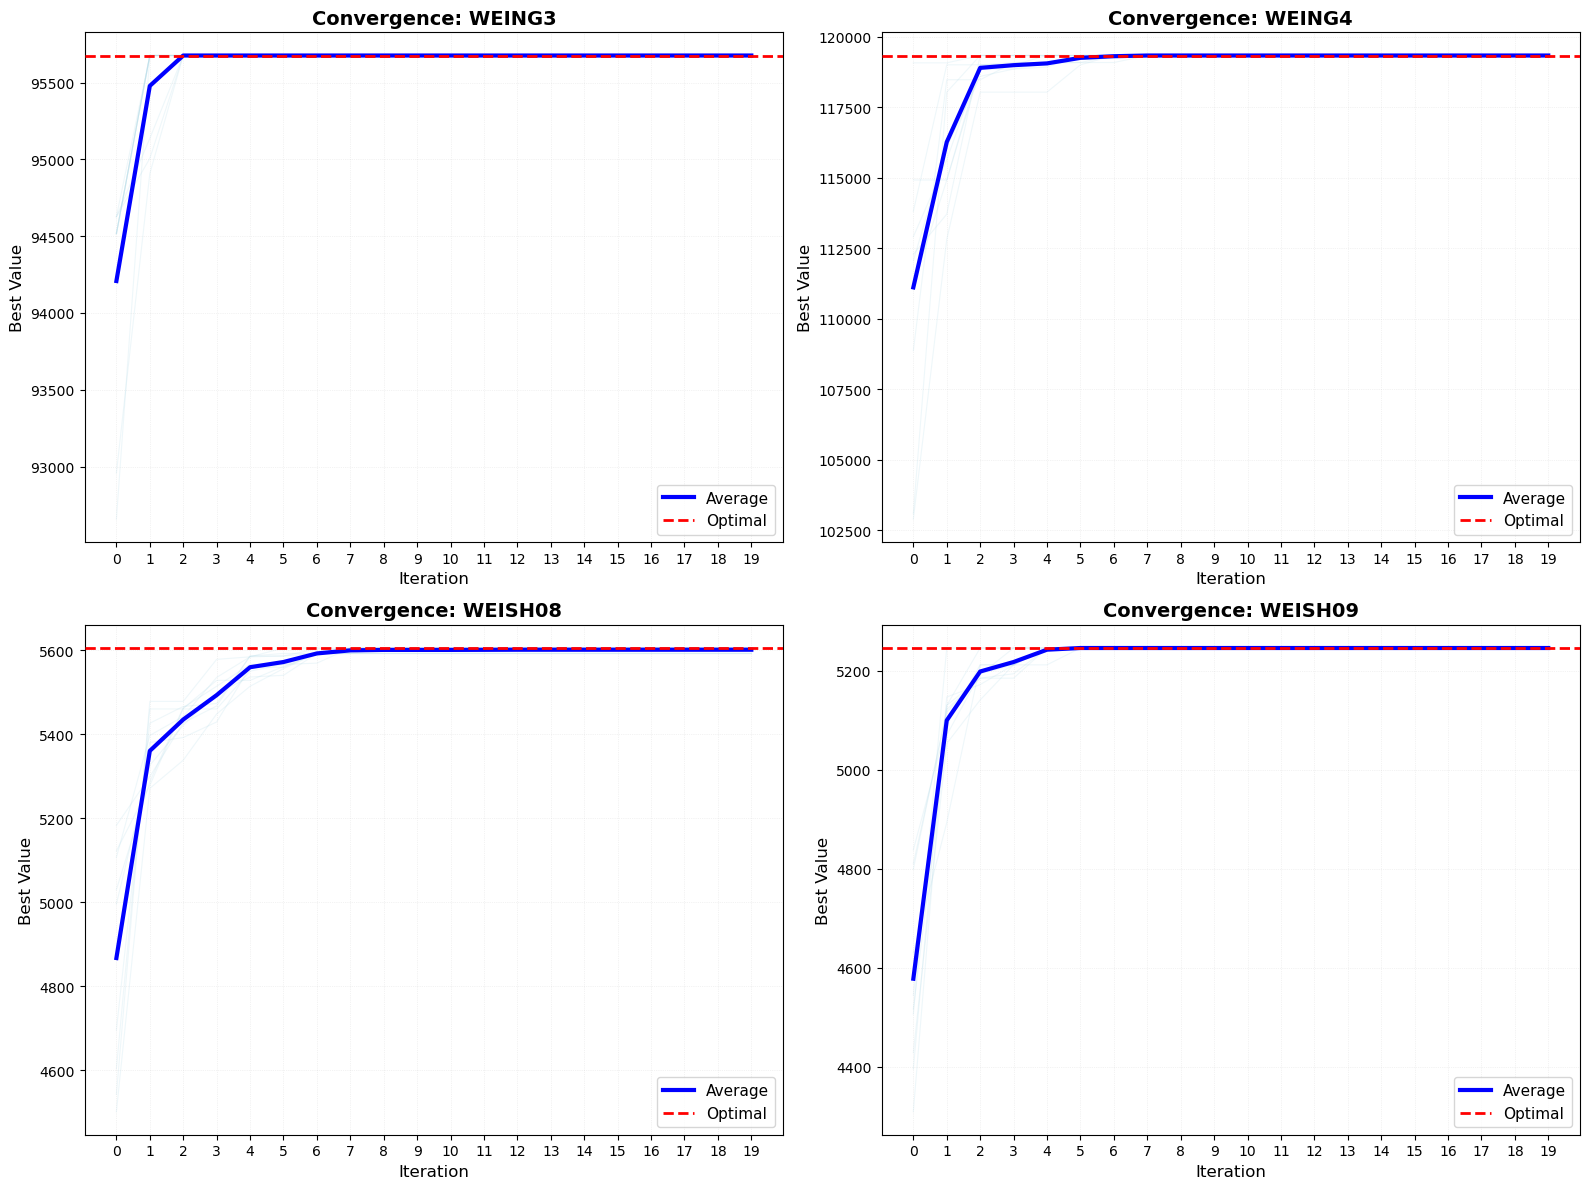


✓ Figure 1: First 4 instances plotted


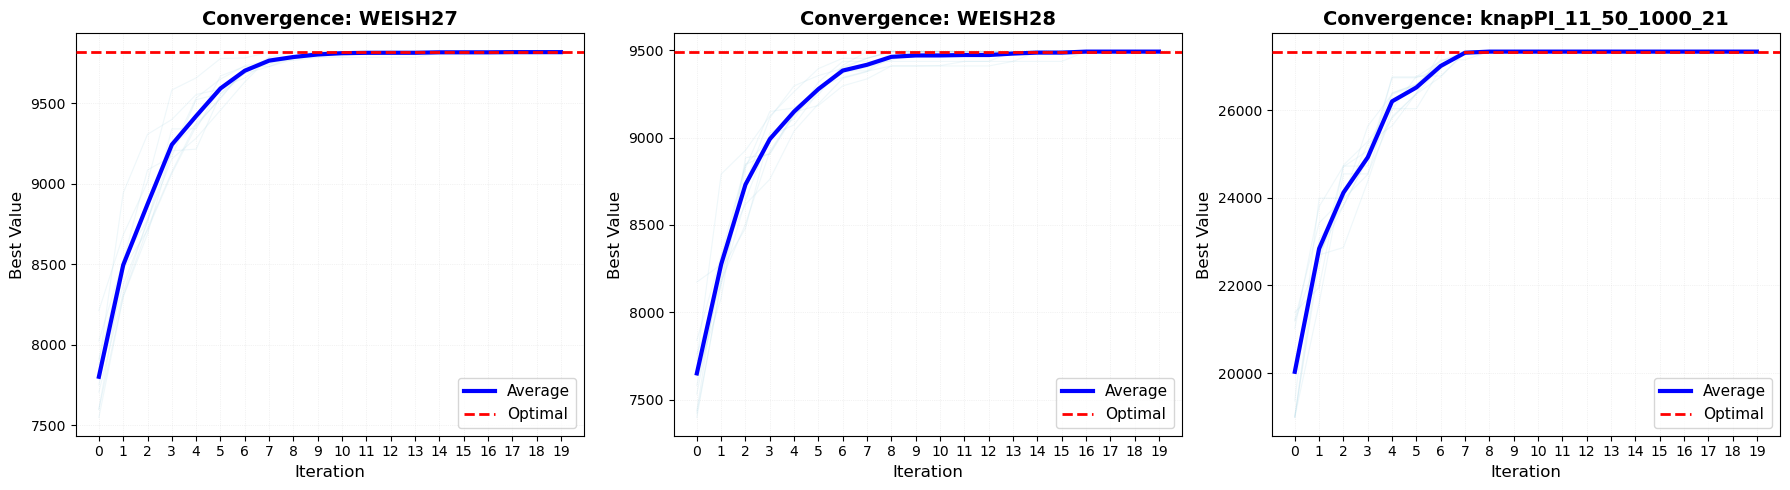

In [7]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("Loading instances...")

loader = DataLoader()

# --------------------------------------------------------------------------
# 1) Load OR-Library instances (using folder structure where cwd = Problem 3/)
# --------------------------------------------------------------------------
or_instances = loader.load_or_library(
    "data/OR-Library/mknap2.txt",
    ['WEING3', 'WEING4', 'WEISH08', 'WEISH09', 'WEISH27', 'WEISH28']
)

# --------------------------------------------------------------------------
# 2) Load one Pisinger instance  (also from data/...)
# --------------------------------------------------------------------------
pisinger_instance = loader.load_pisinger(
    "data/PisingerHard/knapPI_11_50_1000.csv",
    'knapPI_11_50_1000_21'
)

# Collect all instances in one list
all_instances = or_instances + [pisinger_instance]

print(f"Loaded {len(all_instances)} instances")
for inst in all_instances:
    print(f"  - {inst.name}: {inst.num_items} items, {inst.num_knapsacks} knapsacks")

# ============================================================================
# CONFIGURE AND RUN EXPERIMENTS
# ============================================================================
ba_params = {
    'num_scout_bees': 150,
    'num_selected_sites': 30,
    'num_elite_sites': 15,
    'num_bees_elite': 80,
    'num_bees_selected': 40,
    'max_iterations': 20,
    'initial_neighborhood_size': 15,
    'shrinking_factor': 0.8,
    'stagnation_limit': 20
}

runner = ExperimentRunner(all_instances)
runner.run_all_instances(num_runs=10, ba_params=ba_params)

# ============================================================================
# 1. RESULTS TABLE
# ============================================================================
summary_df = runner.generate_summary_table()

task_required_columns = [
    'Instance',           # instance name
    'n',                  # number of items
    'W',                  # capacity
    'Best Value',         # best value found
    'Weight Used',        # weight used
    'Baseline',           # baseline (greedy) value
    'Improvement (%)',    # improvement over baseline
    'Avg Runtime (s)',    # Average runtime
    'Avg Iter to Best',   # Average iteration to best
    'Avg Pop Fitness'     # Average population fitness
]

task_table = summary_df[task_required_columns].copy()

# Format numeric columns
task_table['Best Value'] = task_table['Best Value'].astype(int)
task_table['Weight Used'] = task_table['Weight Used'].round(1)
task_table['Baseline'] = task_table['Baseline'].astype(int)
task_table['Improvement (%)'] = task_table['Improvement (%)'].round(2)
task_table['Avg Runtime (s)'] = task_table['Avg Runtime (s)'].round(2)
task_table['Avg Iter to Best'] = task_table['Avg Iter to Best'].round(1)
task_table['Avg Pop Fitness'] = task_table['Avg Pop Fitness'].round(1)

print("\n" + "="*100)
print("RESULTS TABLE")
print("="*100)

styled_table = task_table.style \
    .format({
        'Best Value': '{:,}',
        'Weight Used': '{:.1f}',
        'Baseline': '{:,}',
        'Improvement (%)': '{:.2f}%',
        'Avg Runtime (s)': '{:.2f}',
        'Avg Iter to Best': '{:.1f}',
        'Avg Pop Fitness': '{:,.1f}'
    }) \
    .set_properties(**{
        'text-align': 'right',
        'font-family': 'monospace'
    }) \
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td:first-child', 'props': [('text-align', 'left')]}
    ])

try:
    from IPython.display import display
    display(styled_table)
except:
    print(task_table.to_string(index=False, float_format=lambda x: f'{x:.2f}'))

print("="*100)

# ============================================================================
# 2. STATISTICS OVER 10 RUNS
# ============================================================================
print("\n" + "="*100)
print("STATISTICS OF FINAL BEST VALUES OVER 10 RUNS")
print("="*100)

statistics_columns = [
    'Instance',
    'Best Value',     # Best across 10 runs
    'Avg Value',      # Average across 10 runs
    'Std Dev',        # Standard deviation
    'Worst Value'     # Worst across 10 runs
]

stats_table = summary_df[statistics_columns].copy()

# Format numeric columns
stats_table['Best Value'] = stats_table['Best Value'].astype(int)
stats_table['Avg Value'] = stats_table['Avg Value'].round(1)
stats_table['Std Dev'] = stats_table['Std Dev'].round(2)
stats_table['Worst Value'] = stats_table['Worst Value'].astype(int)

styled_stats = stats_table.style \
    .format({
        'Best Value': '{:,}',
        'Avg Value': '{:,.1f}',
        'Std Dev': '{:.2f}',
        'Worst Value': '{:,}'
    }) \
    .set_properties(**{
        'text-align': 'right',
        'font-family': 'monospace'
    }) \
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td:first-child', 'props': [('text-align', 'left')]}
    ]) \
    .background_gradient(subset=['Std Dev'], cmap='RdYlGn_r',
                         vmin=0, vmax=stats_table['Std Dev'].max())

try:
    display(styled_stats)
except:
    print(stats_table.to_string(index=False, float_format=lambda x: f'{x:.2f}'))

print("="*100)

# ============================================================================
# 3. CONVERGENCE PLOTS
# ============================================================================
print("\n" + "="*100)
print("CONVERGENCE PLOTS: ITERATION vs BEST VALUE")
print("="*100)

# FIGURE 1: First 4 instances (2x2 grid)
fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
axes1 = axes1.flatten()

for idx in range(min(4, len(runner.results))):
    result = runner.results[idx]
    ax = axes1[idx]

    for run in result['run_results']:
        ax.plot(run['convergence'], alpha=0.2, color='lightblue', linewidth=0.8)

    all_conv = [r['convergence'] for r in result['run_results']]
    max_len = max(len(c) for c in all_conv)
    avg_conv = [np.mean([c[i] for c in all_conv if i < len(c)]) for i in range(max_len)]
    ax.plot(avg_conv, color='blue', linewidth=3, label='Average', zorder=5)

    if result['instance'].optimal_value:
        ax.axhline(y=result['instance'].optimal_value, color='red',
                   linestyle='--', linewidth=2, label='Optimal', zorder=10)

    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Best Value', fontsize=12)
    ax.set_title(f'Convergence: {result['instance'].name}',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

plt.tight_layout()
plt.show()

print("\n✓ Figure 1: First 4 instances plotted")

# FIGURE 2: Remaining instances (if any)
if len(runner.results) > 4:
    fig2, axes2 = plt.subplots(1, len(runner.results) - 4, figsize=(18, 5))
    if len(runner.results) - 4 == 1:
        axes2 = [axes2]

    for idx in range(4, len(runner.results)):
        result = runner.results[idx]
        ax = axes2[idx - 4]

        for run in result['run_results']:
            ax.plot(run['convergence'], alpha=0.2, color='lightblue', linewidth=0.8)

        all_conv = [r['convergence'] for r in result['run_results']]
        max_len = max(len(c) for c in all_conv)
        avg_conv = [np.mean([c[i] for c in all_conv if i < len(c)]) for i in range(max_len)]
        ax.plot(avg_conv, color='blue', linewidth=3, label='Average', zorder=5)

        if result['instance'].optimal_value:
            ax.axhline(y=result['instance'].optimal_value, color='red',
                       linestyle='--', linewidth=2, label='Optimal', zorder=10)

        ax.set_xlabel('Iteration', fontsize=12)
        ax.set_ylabel('Best Value', fontsize=12)
        ax.set_title(f'Convergence: {result["instance"].name}',
                     fontsize=14, fontweight='bold')
        ax.legend(fontsize=11, loc='lower right')
        ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

    plt.tight_layout()
    plt.show()

print("="*100)


SENSITIVITY ANALYIS

Running sensitivity analysis on WEISH27...
Instance: 90 items, 5 knapsacks
Optimal value: 9819
Testing num_bees_elite (nre)...
  nre=15: avg=9808.0, std=12.9
  nre=30: avg=9808.0, std=12.9
  nre=45: avg=9812.6, std=3.2
  nre=60: avg=9812.6, std=3.2
  nre=80: avg=9815.8, std=3.9

Testing num_bees_selected (nrb)...
  nrb=10: avg=9815.8, std=3.9
  nrb=20: avg=9815.8, std=3.9
  nrb=30: avg=9815.8, std=3.9
  nrb=40: avg=9815.8, std=3.9
  nrb=50: avg=9815.8, std=3.9

Testing initial_neighborhood_size (ngh)...
  ngh=5: avg=9815.8, std=3.9
  ngh=10: avg=9806.6, std=17.2
  ngh=15: avg=9815.8, std=3.9
  ngh=25: avg=9814.2, std=3.9
  ngh=35: avg=9815.8, std=3.9


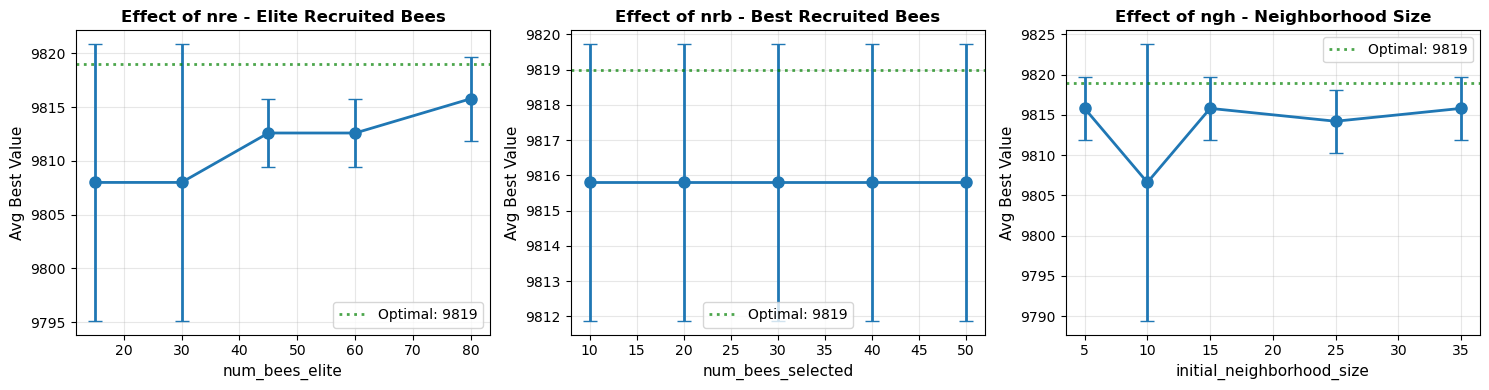

In [8]:
def sensitivity_analysis(instance, n_runs=10):
    """Perform sensitivity analysis on BA parameters with WIDER ranges"""
    
    # Base parameters (same as in your main experiments)
    base_params = {
        'num_scout_bees': 150,
        'num_selected_sites': 30,
        'num_elite_sites': 15,
        'num_bees_elite': 80, 
        'num_bees_selected': 40, 
        'max_iterations': 20,  
        'initial_neighborhood_size': 15, 
        'shrinking_factor': 0.8,    
        'stagnation_limit': 20        
    }
    
    results = {
        'num_bees_elite': {},
        'num_bees_selected': {},
        'initial_neighborhood_size': {}
    }
    
    # ------------------------------------------------------------
    # 1) Test num_bees_elite (nre)
    # ------------------------------------------------------------
    print("Testing num_bees_elite (nre)...")
    nre_vals = [15, 30, 45, 60, 80]
    results['num_bees_elite']['x'] = nre_vals
    results['num_bees_elite']['y'] = []
    results['num_bees_elite']['std'] = []
    
    for nre in nre_vals:
        runs = []
        for seed in range(n_runs):
            ba = BeesAlgorithmStandard(
                instance,
                num_scout_bees=base_params['num_scout_bees'],
                num_selected_sites=base_params['num_selected_sites'],
                num_elite_sites=base_params['num_elite_sites'],
                num_bees_elite=nre,
                num_bees_selected=base_params['num_bees_selected'],
                max_iterations=base_params['max_iterations'],
                initial_neighborhood_size=base_params['initial_neighborhood_size'],
                shrinking_factor=base_params['shrinking_factor'],
                stagnation_limit=base_params['stagnation_limit'],
                random_seed=seed
            )
            _, best_val, _ = ba.optimize()
            runs.append(best_val)
        results['num_bees_elite']['y'].append(np.mean(runs))
        results['num_bees_elite']['std'].append(np.std(runs))
        print(f"  nre={nre}: avg={np.mean(runs):.1f}, std={np.std(runs):.1f}")
    
    # ------------------------------------------------------------
    # 2) Test num_bees_selected (nrb)
    # ------------------------------------------------------------
    print("\nTesting num_bees_selected (nrb)...")
    nrb_vals = [10, 20, 30, 40, 50]
    results['num_bees_selected']['x'] = nrb_vals
    results['num_bees_selected']['y'] = []
    results['num_bees_selected']['std'] = []
    
    for nrb in nrb_vals:
        runs = []
        for seed in range(n_runs):
            ba = BeesAlgorithmStandard(
                instance,
                num_scout_bees=base_params['num_scout_bees'],
                num_selected_sites=base_params['num_selected_sites'],
                num_elite_sites=base_params['num_elite_sites'],
                num_bees_elite=base_params['num_bees_elite'],
                num_bees_selected=nrb,
                max_iterations=base_params['max_iterations'],
                initial_neighborhood_size=base_params['initial_neighborhood_size'],
                shrinking_factor=base_params['shrinking_factor'],
                stagnation_limit=base_params['stagnation_limit'],
                random_seed=seed
            )
            _, best_val, _ = ba.optimize()
            runs.append(best_val)
        results['num_bees_selected']['y'].append(np.mean(runs))
        results['num_bees_selected']['std'].append(np.std(runs))
        print(f"  nrb={nrb}: avg={np.mean(runs):.1f}, std={np.std(runs):.1f}")
    
    # ------------------------------------------------------------
    # 3) Test initial_neighborhood_size (ngh)
    # ------------------------------------------------------------
    print("\nTesting initial_neighborhood_size (ngh)...")
    ngh_vals = [5, 10, 15, 25, 35]
    results['initial_neighborhood_size']['x'] = ngh_vals
    results['initial_neighborhood_size']['y'] = []
    results['initial_neighborhood_size']['std'] = []
    
    for ngh in ngh_vals:
        runs = []
        for seed in range(n_runs):
            ba = BeesAlgorithmStandard(
                instance,
                num_scout_bees=base_params['num_scout_bees'],
                num_selected_sites=base_params['num_selected_sites'],
                num_elite_sites=base_params['num_elite_sites'],
                num_bees_elite=base_params['num_bees_elite'],
                num_bees_selected=base_params['num_bees_selected'],
                max_iterations=base_params['max_iterations'],
                initial_neighborhood_size=ngh,
                shrinking_factor=base_params['shrinking_factor'],
                stagnation_limit=base_params['stagnation_limit'],
                random_seed=seed
            )
            _, best_val, _ = ba.optimize()
            runs.append(best_val)
        results['initial_neighborhood_size']['y'].append(np.mean(runs))
        results['initial_neighborhood_size']['std'].append(np.std(runs))
        print(f"  ngh={ngh}: avg={np.mean(runs):.1f}, std={np.std(runs):.1f}")
    
    return results, base_params


# -------------------------------------------------------------------------
# Choose a representative "hard" instance from your loaded instances
# Now: use WEISH27 (5 knapsacks, many items) instead of WEISH26
# -------------------------------------------------------------------------
try:
    representative_instance = next(inst for inst in all_instances if inst.name == 'WEISH27')
except StopIteration:
    # Fallback if name not found (should not happen if loading is correct)
    representative_instance = all_instances[-1]

print(f"Running sensitivity analysis on {representative_instance.name}...")
print(f"Instance: {representative_instance.num_items} items, "
      f"{representative_instance.num_knapsacks} knapsacks")
print(f"Optimal value: {representative_instance.optimal_value}")

results, base_params = sensitivity_analysis(representative_instance, n_runs=5)

# -------------------------------------------------------------------------
# Plot sensitivity curves
# -------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

params_info = [
    ('num_bees_elite', 'nre - Elite Recruited Bees'),
    ('num_bees_selected', 'nrb - Best Recruited Bees'),
    ('initial_neighborhood_size', 'ngh - Neighborhood Size')
]

for i, (param, title) in enumerate(params_info):
    ax = axes[i]
    ax.errorbar(
        results[param]['x'],
        results[param]['y'],
        yerr=results[param]['std'],
        marker='o',
        capsize=5,
        linewidth=2,
        markersize=8
    )
    
    if representative_instance.optimal_value:
        ax.axhline(
            y=representative_instance.optimal_value,
            color='green',
            linestyle=':',
            linewidth=2,
            alpha=0.7,
            label=f'Optimal: {representative_instance.optimal_value}'
        )
        
    ax.set_xlabel(param, fontsize=11)
    ax.set_ylabel('Avg Best Value', fontsize=11)
    ax.set_title(f'Effect of {title}', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()
